In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [3]:
# -------------------------------------------
# 2. Basic Settings and Data Paths
# -------------------------------------------
dataset_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "valid")
batch_size = 32
img_size = 224
epochs = 3  # Increased for ResNet

In [4]:
# -------------------------------------------
# 3. Data Preparation and Generation
# -------------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [8]:
# -------------------------------------------
# 4. Build CNN Model
# -------------------------------------------
def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [9]:
# -------------------------------------------
# 5. Build ResNet Model with Improvements
# -------------------------------------------
def build_resnet_model():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    
    # Fine-tune more layers (last 50 layers)
    for layer in base_model.layers[-50:]:
        layer.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False
        
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),  # Increased units
        layers.BatchNormalization(),
        layers.Dropout(0.4),  # Adjusted dropout
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [11]:
# -------------------------------------------
# 6. Build Inception-ResNet-V2 Model
# -------------------------------------------
def build_inception_model():
    base_model = InceptionResNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
        
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [13]:
# -------------------------------------------
# 7. Train Models
# -------------------------------------------
# Callbacks for ResNet
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-6)

In [15]:
# Train Inception-ResNet-V2
inception_model = build_inception_model()
print("\n--- Training Inception-ResNet-V2 Model ---")
history_inception = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1,  # Keep 1 epoch for Inception
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)


--- Training Inception-ResNet-V2 Model ---
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1191s 524ms/step - accuracy: 0.6655 - loss: 1.2271 - val_accuracy: 0.9364 - val_loss: 0.1946


In [17]:
# Train CNN
cnn_model = build_cnn_model()
print("\n--- Training CNN Model ---")
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1,  # Keep 1 epoch for CNN
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)



--- Training CNN Model ---
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 895s 405ms/step - accuracy: 0.3093 - loss: 2.4712 - val_accuracy: 0.6935 - val_loss: 0.9804


In [18]:
# Train ResNet
resnet_model = build_resnet_model()
print("\n--- Training ResNet Model ---")
history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1,  
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Training ResNet Model ---
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 977s 428ms/step - accuracy: 0.1700 - loss: 3.3417 - val_accuracy: 0.0448 - val_loss: 31.1074 - learning_rate: 1.0000e-04



=== Evaluating Models ===

Evaluating CNN Model...
550/550 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step - accuracy: 0.6855 - loss: 1.0096

Model CNN Test Accuracy: 0.6935, Test Loss: 0.9802
550/550 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step

Detailed Classification Report for CNN:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.70      0.60      0.65       504
                                 Apple___Black_rot       0.79      0.63      0.70       497
                          Apple___Cedar_apple_rust       0.99      0.46      0.63       440
                                   Apple___healthy       0.47      0.79      0.59       502
                               Blueberry___healthy       0.73      0.84      0.78       454
          Cherry_(including_sour)___Powdery_mildew       0.93      0.46      0.62       421
                 Cherry_(including_sour)___healthy       0.95      0.58      0.72       45

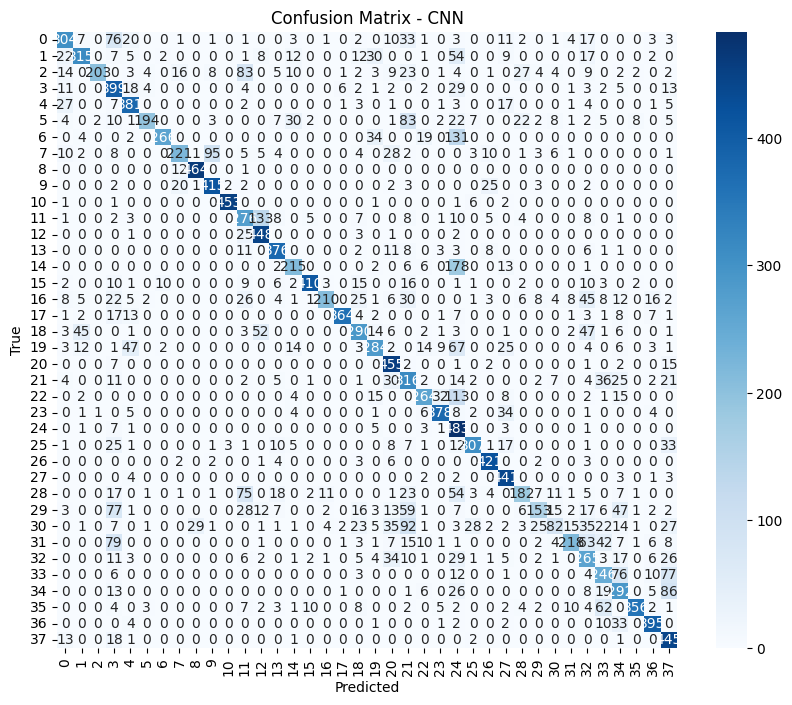


Evaluating ResNet Model...
550/550 ━━━━━━━━━━━━━━━━━━━━ 54s 97ms/step - accuracy: 0.0589 - loss: 29.1654

Model ResNet Test Accuracy: 0.0448, Test Loss: 31.1037
550/550 ━━━━━━━━━━━━━━━━━━━━ 51s 93ms/step

Detailed Classification Report for ResNet:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       504
                                 Apple___Black_rot       0.00      0.00      0.00       497
                          Apple___Cedar_apple_rust       0.00      0.00      0.00       440
                                   Apple___healthy       0.00      0.00      0.00       502
                               Blueberry___healthy       0.00      0.00      0.00       454
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       421
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       456
Corn_(maize)__

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


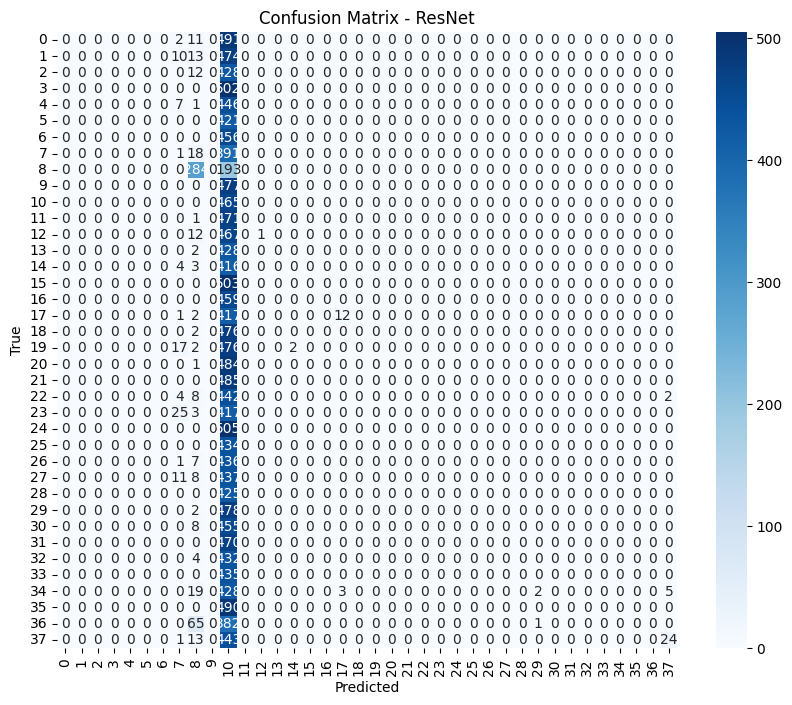


Evaluating Inception-ResNet-V2 Model...
550/550 ━━━━━━━━━━━━━━━━━━━━ 87s 157ms/step - accuracy: 0.9615 - loss: 0.1216

Model InceptionResNetV2 Test Accuracy: 0.9364, Test Loss: 0.1946
550/550 ━━━━━━━━━━━━━━━━━━━━ 86s 157ms/step

Detailed Classification Report for InceptionResNetV2:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.94      0.97       504
                                 Apple___Black_rot       0.98      0.99      0.98       497
                          Apple___Cedar_apple_rust       0.98      0.99      0.98       440
                                   Apple___healthy       0.98      0.96      0.97       502
                               Blueberry___healthy       0.94      1.00      0.97       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.97      0.98       421
                 Cherry_(including_sour)___healthy       0.98      1.00

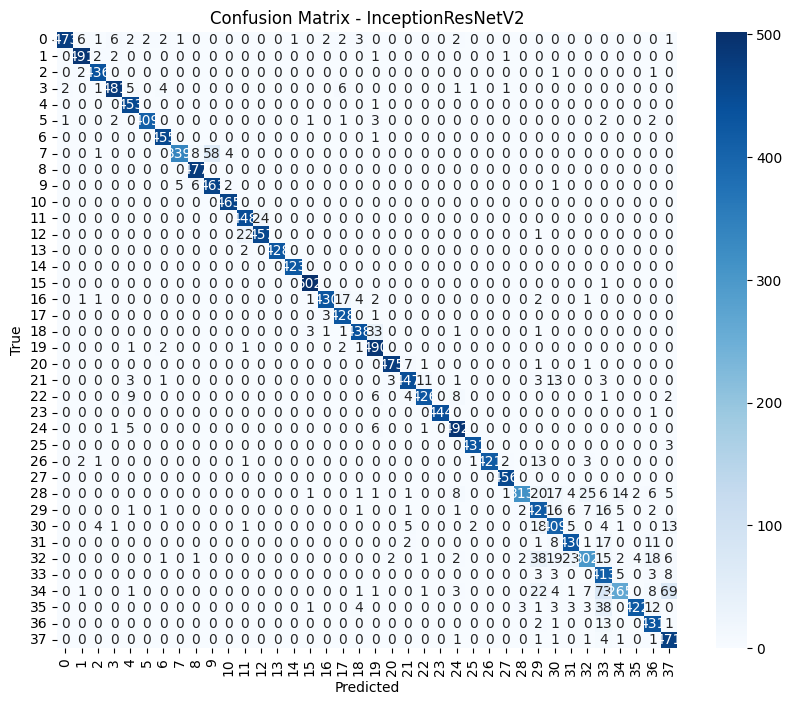

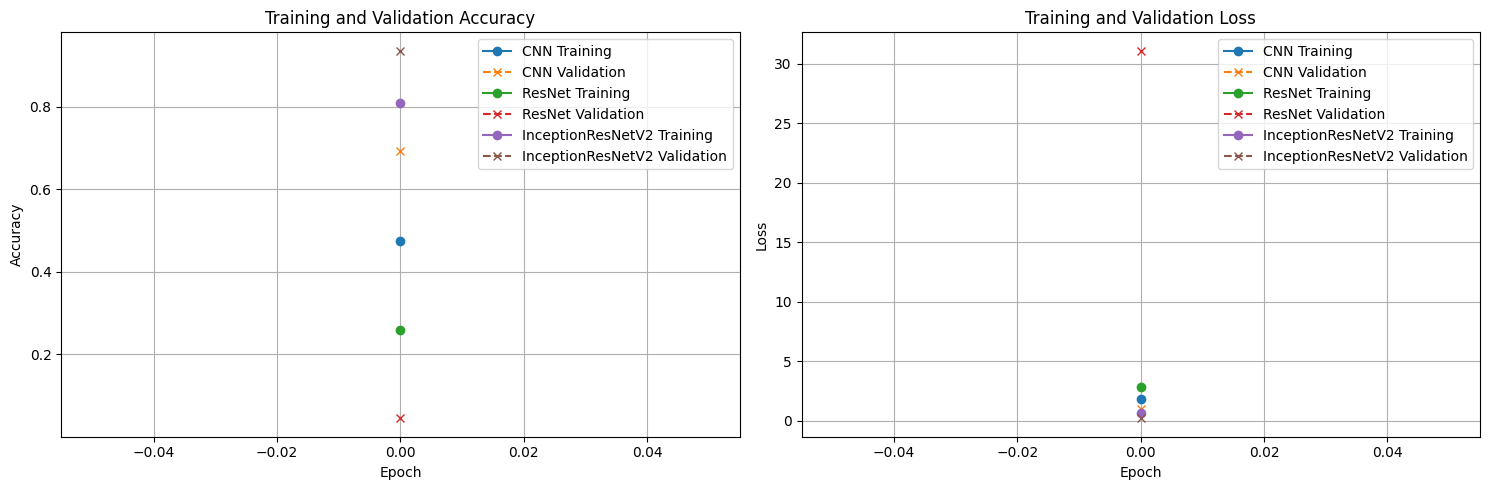


Model Comparison Table:
               Model  Test Accuracy  Test Loss
0                CNN       0.693547   0.980185
1             ResNet       0.044787  31.103748
2  InceptionResNetV2       0.936433   0.194551
Comparison table saved as 'model_comparison.csv'


In [45]:
# -------------------------------------------
# 8. Evaluation Functions
# -------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# List to store evaluation results
results = []

def evaluate_model(model, history, model_name, test_generator):
    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_generator)
    print(f'\nModel {model_name} Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')
    
    # Store results
    results.append({
        'Model': model_name,
        'Test Accuracy': test_acc,
        'Test Loss': test_loss
    })
    
    # Predictions and classification report
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print(f"\nDetailed Classification Report for {model_name}:")
    print(classification_report(test_generator.classes, y_pred_classes,
                                target_names=list(test_generator.class_indices.keys())))
    
    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(test_generator.classes, y_pred_classes), 
                annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()  # Display the plot
    plt.close()
    
    return history, test_acc, test_loss

def plot_comparative_metrics(histories, model_names):
    plt.figure(figsize=(15, 5))
    
    # Training and validation accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], marker='o', label=f'{name} Training')
        plt.plot(history.history['val_accuracy'], marker='x', linestyle='--', label=f'{name} Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Training and validation loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], marker='o', label=f'{name} Training')
        plt.plot(history.history['val_loss'], marker='x', linestyle='--', label=f'{name} Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('comparative_metrics.png')
    plt.show()  # Display the plot
    plt.close()

def save_comparison_table(results):
    df = pd.DataFrame(results)
    df.to_csv('model_comparison.csv', index=False)
    print("\nModel Comparison Table:")
    print(df)
    print("Comparison table saved as 'model_comparison.csv'")

# -------------------------------------------
# 9. Execute Evaluation
# -------------------------------------------
print("\n=== Evaluating Models ===")

# Lists to store histories
histories = []
model_names = ["CNN", "ResNet", "InceptionResNetV2"]

# Evaluate CNN
print("\nEvaluating CNN Model...")
history_cnn, cnn_acc, cnn_loss = evaluate_model(cnn_model, history_cnn, "CNN", test_generator)
histories.append(history_cnn)

# Evaluate ResNet
print("\nEvaluating ResNet Model...")
history_resnet, resnet_acc, resnet_loss = evaluate_model(resnet_model, history_resnet, "ResNet", test_generator)
histories.append(history_resnet)

# Evaluate Inception-ResNet-V2
print("\nEvaluating Inception-ResNet-V2 Model...")
history_inception, inception_acc, inception_loss = evaluate_model(inception_model, history_inception, "InceptionResNetV2", test_generator)
histories.append(history_inception)

# Plot comparative metrics
plot_comparative_metrics(histories, model_names)

# Save comparison table
save_comparison_table(results)

In [47]:
# -------------------------------------------
# 10. Save Models
# -------------------------------------------
os.makedirs('saved_models', exist_ok=True)

cnn_model.save('saved_models/plant_disease_cnn.h5')
print("\nCNN Model saved at: saved_models/plant_disease_cnn.h5")

resnet_model.save('saved_models/plant_disease_resnet.h5')
print("ResNet Model saved at: saved_models/plant_disease_resnet.h5")

inception_model.save('saved_models/plant_disease_inception.h5')
print("Inception-ResNet-V2 Model saved at: saved_models/plant_disease_inception.h5")


CNN Model saved at: saved_models/plant_disease_cnn.h5
ResNet Model saved at: saved_models/plant_disease_resnet.h5
Inception-ResNet-V2 Model saved at: saved_models/plant_disease_inception.h5


In [48]:
import os
print("Saved files:", os.listdir('saved_models'))

Saved files: ['plant_disease_cnn.h5', 'plant_disease_resnet.h5', 'plant_disease_inception.h5']


In [49]:
print(os.listdir('/kaggle/working/saved_models'))

['plant_disease_cnn.h5', 'plant_disease_resnet.h5', 'plant_disease_inception.h5']
